In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from scipy.integrate import solve_ivp

transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values
])

# Load MNIST dataset
batch_size = 128
train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [4]:
# Pendulum Parameters
g = 9.81  # Gravity
l = 1.0   # Length
k = 0.05  # Damping
f_min, f_max = 1.0, 2.0  # Encoding range
omega_fixed = 1.0  # Fixed frequency
dt = 0.01
T = 1  # Shorter time for efficiency

def pendulum_dynamics(t, state, f, omega):
    """ Defines the pendulum equation of motion with forcing. """
    x, v = state
    dxdt = v
    dvdt = -g/l * np.sin(x) - k * v + f * np.sign(np.sin(omega * t))
    return [dxdt, dvdt]

def simulate_pendulum(f, omega, init_state=[0, 0], duration=T, dt=dt):
    """ Runs pendulum for given input force. """
    t_span = (0, duration)
    t_eval = np.arange(0, duration, dt)
    sol = solve_ivp(pendulum_dynamics, t_span, init_state, t_eval=t_eval, args=(f, omega))
    return sol.y[0]  # Return transient position as features


/tmp/ipykernel_7125/1070640557.py:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(reservoir_features, dtype=torch.float32)


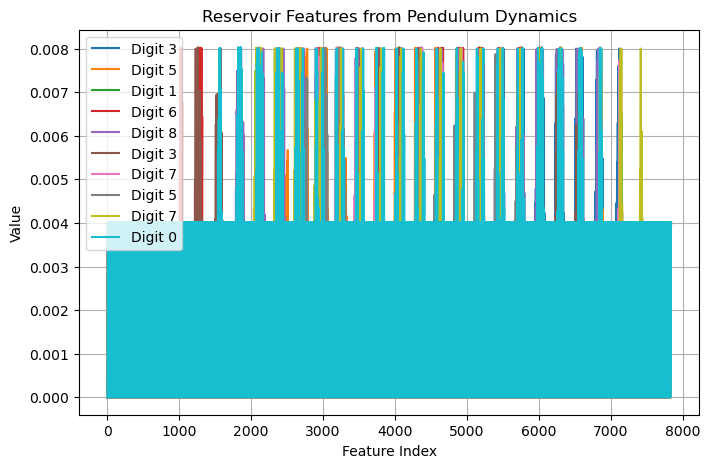

In [5]:
def extract_reservoir_features(images):
    """ Converts an MNIST image batch into reservoir states using pendulum dynamics. """
    batch_size = images.shape[0]
    images = images.view(batch_size, -1)  # Flatten images (28x28 -> 784)
    
    reservoir_features = []
    for img in images:
        features = []
        for pixel in img:
            f = f_min + (f_max - f_min) * (pixel.item() + 1) / 2  # Normalize pixel [-1,1] -> [1,2]
            omega = omega_fixed
            state = simulate_pendulum(f, omega)
            features.append(state[:10])  # Take first 10 transient states as features
        reservoir_features.append(np.concatenate(features))  # Flatten all features
    
    return torch.tensor(reservoir_features, dtype=torch.float32)

# Test feature extraction on one batch
sample_images, sample_labels = next(iter(train_loader))
sample_features = extract_reservoir_features(sample_images[:10])

plt.figure(figsize=(8, 5))
for i in range(10):
    plt.plot(sample_features[i].numpy(), label=f"Digit {sample_labels[i].item()}")
plt.title("Reservoir Features from Pendulum Dynamics")
plt.xlabel("Feature Index")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()


In [6]:
class ReadoutClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(ReadoutClassifier, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)  # Single-layer classifier
    
    def forward(self, x):
        return self.fc(x)

# Model Parameters
input_dim = sample_features.shape[1]  # Features extracted from pendulum
num_classes = 10  # MNIST Digits (0-9)

model = ReadoutClassifier(input_dim, num_classes)


In [ ]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
print(f"Using device: {device}")

# Move model to GPU
model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 5
train_losses = []

for epoch in range(num_epochs):
    epoch_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        X_train = extract_reservoir_features(images)  # Encode images
        X_train = X_train.to(device)  # Move features to GPU
        y_train = labels
        
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# Plot Loss Curve
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()


Using device: cpu


In [ ]:
def evaluate(model, dataloader):
    """ Evaluates model accuracy on test data. """
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            X_test = extract_reservoir_features(images)
            outputs = model(X_test)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return correct / total

# Compute accuracy
train_acc = evaluate(model, train_loader)
test_acc = evaluate(model, test_loader)

print(f"Train Accuracy: {train_acc * 100:.2f}%")
print(f"Test Accuracy: {test_acc * 100:.2f}%")


In [ ]:
# Pick random test images
test_images, test_labels = next(iter(test_loader))
X_test = extract_reservoir_features(test_images[:10])

with torch.no_grad():
    outputs = model(X_test)
    _, predicted_labels = torch.max(outputs, 1)

# Plot Predictions
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(test_images[i][0], cmap='gray')
    ax.set_title(f"Pred: {predicted_labels[i].item()}")
    ax.axis("off")

plt.tight_layout()
plt.show()
